# LBT Demo: Block Sizes 16, 8, 4
Estudio del efecto del tamaño de bloque (Block Size `-B`) en el Learned Block Transform (LBT).

Este notebook ejecuta el codificador LBT con tres tamaños de bloque diferentes y muestra los resultados visuales y el tamaño de los archivos generados.

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_images(original_path, encoded_path, decoded_path, title):
    """
    Función para visualizar y comparar las imágenes original, codificada y decodificada.
    
    Parámetros:
        original_path: ruta a la imagen original
        encoded_path: ruta a la imagen codificada (coeficientes)
        decoded_path: ruta a la imagen decodificada
        title: título para la visualización
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Mostrar imagen original
    if os.path.exists(original_path):
        img = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
        axs[0].imshow(img)
        axs[0].set_title(f'Original\nTamaño: {os.path.getsize(original_path)/1024:.1f} KB')
    else:
        axs[0].text(0.5, 0.5, 'No encontrada', ha='center')
    axs[0].axis('off')
    
    # Mostrar imagen codificada (Coeficientes)
    # Nota: Se muestra el archivo de coeficientes como imagen. Puede parecer ruido o bloques.
    if os.path.exists(encoded_path):
        try:
            # Intentar leer con OpenCV (maneja archivos TIF)
            img_enc = cv2.imread(encoded_path, cv2.IMREAD_UNCHANGED)
            if img_enc is not None:
                if len(img_enc.shape) == 3:
                     # Convertir BGR a RGB si es imagen de color
                     img_enc = cv2.cvtColor(img_enc, cv2.COLOR_BGR2RGB)
                # Mostrar los coeficientes sin normalización
                axs[1].imshow(img_enc, cmap='gray')
            else:
                 axs[1].text(0.5, 0.5, 'No se pudo leer TIF', ha='center')
        except Exception as e:
             axs[1].text(0.5, 0.5, f'Error: {e}', ha='center')
        
        # Calcular y mostrar tamaños de archivos
        weights_path = encoded_path.replace('.tif', '_weights.bin')
        w_size = os.path.getsize(weights_path) if os.path.exists(weights_path) else 0
        enc_size = os.path.getsize(encoded_path)
        total_size = enc_size + w_size
        axs[1].set_title(f'Coeficientes + Pesos\nTIF: {enc_size/1024:.1f} KB | Pesos: {w_size/1024:.1f} KB\nTotal: {total_size/1024:.1f} KB')
    else:
        axs[1].text(0.5, 0.5, 'No encontrada', ha='center')
    axs[1].axis('off')
    
    # Mostrar imagen decodificada (reconstruida)
    if os.path.exists(decoded_path):
        img_dec = cv2.cvtColor(cv2.imread(decoded_path), cv2.COLOR_BGR2RGB)
        axs[2].imshow(img_dec)
        axs[2].set_title(f'Decodificada\nTamaño: {os.path.getsize(decoded_path)/1024:.1f} KB')
    else:
        axs[2].text(0.5, 0.5, 'No encontrada', ha='center')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
# Configuración de rutas
src_dir = '../src'
docs_dir = '../docs'
img_file = 'hor.jpg'
input_img = f'{docs_dir}/hor.jpg'

# Directorios de salida (rutas relativas al directorio src)
encoded_dir_rel = f'{docs_dir}/encoded'
decoded_dir_rel = f'{docs_dir}/decoded'

# Crear directorios si no existen
# Nota: Estamos en notebooks/, así que ../docs es la ruta relativa correcta
os.makedirs(f'../docs/encoded', exist_ok=True)
os.makedirs(f'../docs/decoded', exist_ok=True)

### Configuración de Calidad
Puedes ajustar `qs` (Quantization Step Size) para controlar la calidad/compresión.
* `qs = 32` (Default): Mayor compresión, menor calidad.
* `qs = 10` (High Quality): Mejor calidad, archivo más grande.

## 1. Bloque 16x16

main Namespace(debug=False, subparser_name='encode', block_size_DCT=16, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=16, entropy_image_codec='TIFF', original='../docs/hor.jpg', encoded='../docs/encoded/demo_B16', func=<function encode at 0x0000019066BC3560>)


(INFO) LBT: Imagen leída: forma=(3280, 4928, 3)
(INFO) entropy_image_coding: Written 1136997 bytes in ../docs/encoded/demo_B16.tif
(INFO) LBT: Codificación completada: tamaño salida = 1136997 bytes


Denoising filter = no_filter
main Namespace(debug=False, subparser_name='decode', block_size_DCT=16, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=16, filter='no_filter', entropy_image_codec='TIFF', encoded='../docs/encoded/demo_B16', decoded='../docs/decoded/demo_B16.jpg', func=<function decode at 0x000001B26F88E7A0>)
205 308


(INFO) LBT: Decodificación completada: tamaño salida = 1033880 bytes


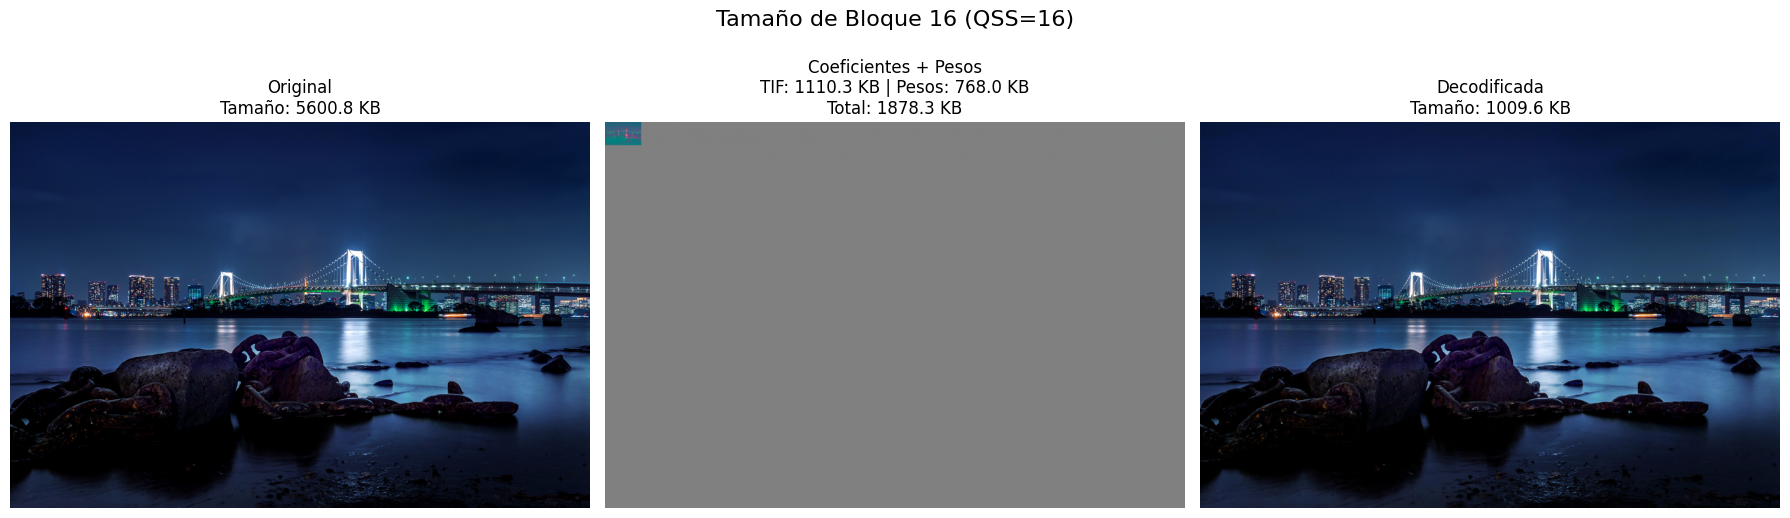

In [10]:
# Tamaño de bloque 16x16
B = 16
qs = 16  # Quantization Step Size (Tamaño de paso de cuantización)
enc_file = f'{encoded_dir_rel}/demo_B{B}'
dec_file = f'{decoded_dir_rel}/demo_B{B}.jpg'

# Ejecutar codificador y decodificador LBT
!cd {src_dir} && python LBT.py encode -o {input_img} -e {enc_file} -B {B} -q {qs}
!cd {src_dir} && python LBT.py decode -e {enc_file} -d {dec_file} -B {B} -q {qs}

# Mostrar resultados visuales (las rutas son relativas al notebook)
show_images(f'../docs/{img_file}', f'../docs/encoded/demo_B{B}.tif', f'../docs/decoded/demo_B{B}.jpg', f'Tamaño de Bloque {B} (QSS={qs})')

In [14]:
# Reducir Quantization Step Size para mejorar la calidad en los siguientes experimentos
qs = 10

## 2. Bloque 8x8 (Estándar)

main Namespace(debug=False, subparser_name='encode', block_size_DCT=8, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=10, entropy_image_codec='TIFF', original='../docs/hor.jpg', encoded='../docs/encoded/demo_B8', func=<function encode at 0x000001E5EF003560>)


(INFO) LBT: Imagen leída: forma=(3280, 4928, 3)
(INFO) entropy_image_coding: Written 1880374 bytes in ../docs/encoded/demo_B8.tif
(INFO) LBT: Codificación completada: tamaño salida = 1880374 bytes


Denoising filter = no_filter
main Namespace(debug=False, subparser_name='decode', block_size_DCT=8, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=10, filter='no_filter', entropy_image_codec='TIFF', encoded='../docs/encoded/demo_B8', decoded='../docs/decoded/demo_B8.jpg', func=<function decode at 0x000001BAFF02E7A0>)
410 616


(INFO) LBT: Decodificación completada: tamaño salida = 1135808 bytes


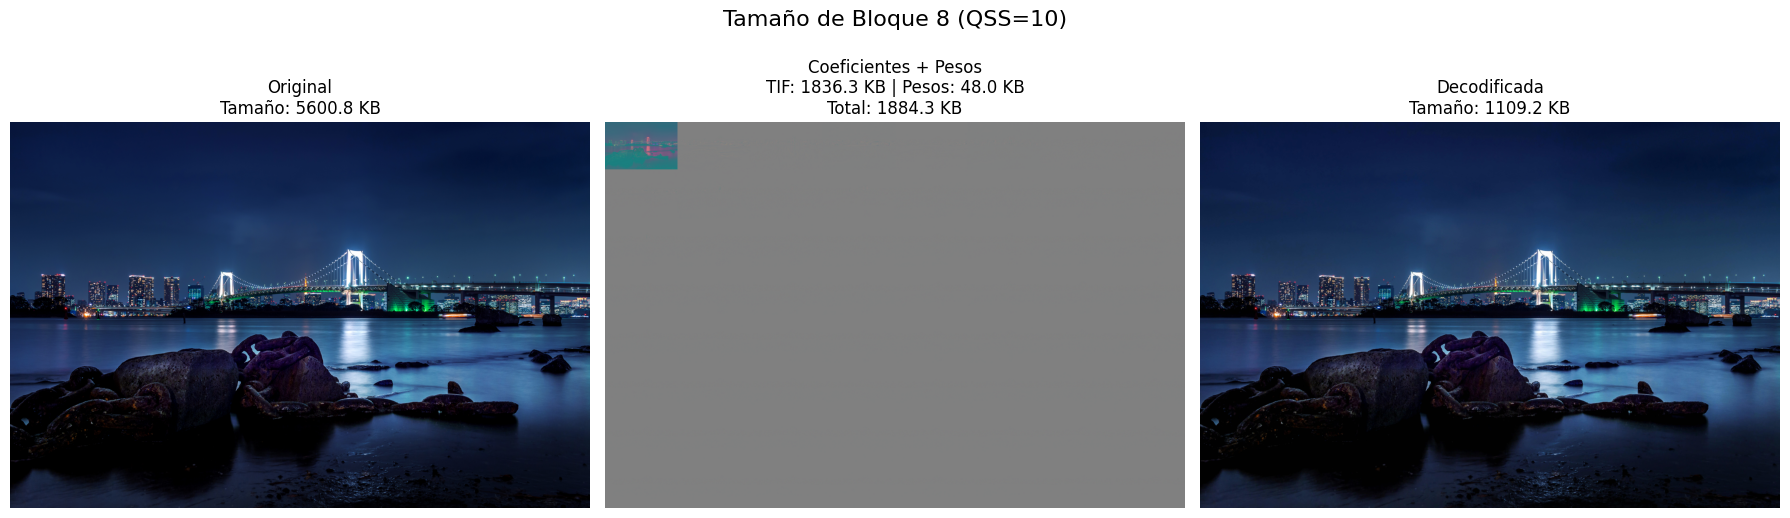

In [15]:
# Tamaño de bloque 8x8 (estándar en compresión de imágenes, como en JPEG)
B = 8
enc_file = f'{encoded_dir_rel}/demo_B{B}'
dec_file = f'{decoded_dir_rel}/demo_B{B}.jpg'

# Ejecutar codificador y decodificador LBT
!cd {src_dir} && python LBT.py encode -o {input_img} -e {enc_file} -B {B} -q {qs}
!cd {src_dir} && python LBT.py decode -e {enc_file} -d {dec_file} -B {B} -q {qs}

# Mostrar y comparar resultados
show_images(f'../docs/{img_file}', f'../docs/encoded/demo_B{B}.tif', f'../docs/decoded/demo_B{B}.jpg', f'Tamaño de Bloque {B} (QSS={qs})')

## 3. Bloque 4x4

main Namespace(debug=False, subparser_name='encode', block_size_DCT=4, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=10, entropy_image_codec='TIFF', original='../docs/hor.jpg', encoded='../docs/encoded/demo_B4', func=<function encode at 0x000001A02C843560>)


(INFO) LBT: Imagen leída: forma=(3280, 4928, 3)
(INFO) entropy_image_coding: Written 2064168 bytes in ../docs/encoded/demo_B4.tif
(INFO) LBT: Codificación completada: tamaño salida = 2064168 bytes


Denoising filter = no_filter
main Namespace(debug=False, subparser_name='decode', block_size_DCT=4, color_transform='YCoCg', disable_subbands=False, quantizer='deadzone', QSS=10, filter='no_filter', entropy_image_codec='TIFF', encoded='../docs/encoded/demo_B4', decoded='../docs/decoded/demo_B4.jpg', func=<function decode at 0x0000029E1517E7A0>)
820 1232


(INFO) LBT: Decodificación completada: tamaño salida = 1252487 bytes


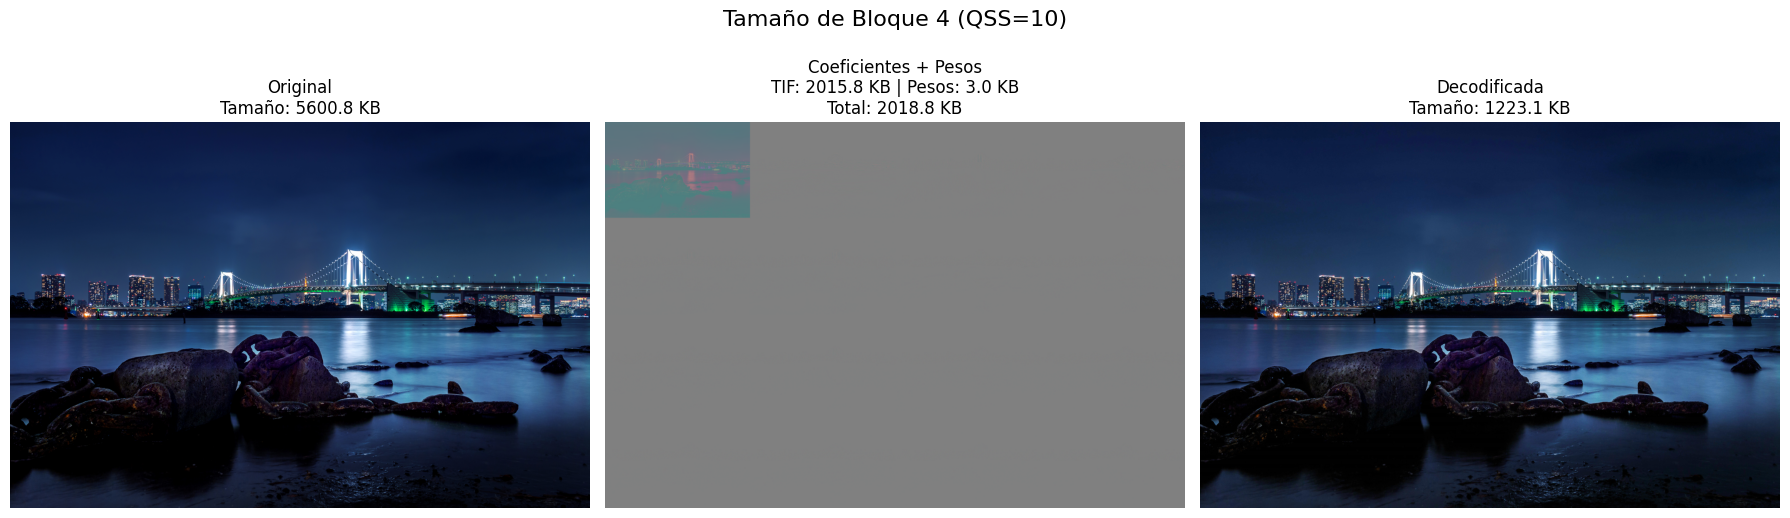

In [16]:
# Tamaño de bloque 4x4 (bloques más pequeños, mayor complejidad computacional)
B = 4
enc_file = f'{encoded_dir_rel}/demo_B{B}'
dec_file = f'{decoded_dir_rel}/demo_B{B}.jpg'

# Ejecutar codificador y decodificador LBT
!cd {src_dir} && python LBT.py encode -o {input_img} -e {enc_file} -B {B} -q {qs}
!cd {src_dir} && python LBT.py decode -e {enc_file} -d {dec_file} -B {B} -q {qs}

# Mostrar y comparar resultados
show_images(f'../docs/{img_file}', f'../docs/encoded/demo_B{B}.tif', f'../docs/decoded/demo_B{B}.jpg', f'Tamaño de Bloque {B} (QSS={qs})')